# SEISMIC INVERSION USING MACHINE LEARNING

This notebook builds an end-to-end Long Short Term Memory Model using XGBoost

## Problem
Geophysics in the Cloud was a competition with the goal to perform seismic inversion of rock attributes from seismic data with the use of well logs. 

## Data
Data used in this project came from open data (3D Poseidon from Australia). Seismic acquisition in 2009 by ConoPhilips
Data given:
- Near, Mid, Far offset seismic
- Migration Velocity
- Sonic Logs
- Gamma
- Porosity
- Resistivity Logs

## Goal
Performing inversions for P-Impedance, S-Impedance, and Density.

## Evaluation

* MAE = (1/n) * Σ|yi – xi|
* R2 = 1 - ${\frac{RSS}{TSS}}$ \\
R^2	=	coefficient of determination \\
RSS	=	sum of squares of residuals \\
TSS	=	total sum of squares \\
* ME: maximum residual error

## Features

1. Well logs with DTC (transit-time of compressional wave), DTS (transit-time of shear wave) and RHOB (bulk density) are used for training and evaluation. 
2. Data is from Two blind wells. 
3. The provided logs contain a large amount of missing data.

Inversion Info:

Equations: \\
Zp = Vp${*}$Rhob \\
Zs = Vs${*}$Rhob

### 1. Get workspace ready

In [35]:
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.misc import derivative
from scipy.interpolate import interp1d
from scipy.signal import hilbert,chirp 

import smooth as sm 

# Scaler
from sklearn.preprocessing import RobustScaler

# Baseline
from sklearn.metrics import mean_absolute_error, r2_score, max_error
from xgboost import XGBRegressor, plot_importance

# Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras as k

### 2. Cleaning and imputing data
Given the size of SEGY files and the lack of computer power I decided to skip the data cleaning and imputation part. 

### 3. Data Engineering and augmentation
- Creating new features from provided data.
- Generate standard AVO attributes.
    * Stack(sum of Near, Mid and Far)
    * Intercept and gradient
    * Rp = Intercept and Rs (Intercept - Gradient)
    * Pseudo_Curvature = Gradient(Far-Mid) - Gradient(Far-Near)
    * Integration of Rp/Intercept(RAIp)
    * Integration of the Rs (RAIs)
    * Integration of the ABS of the Rp and Rs

In [7]:
cleaned_data = pd.read_csv('../Datasets/Seismic Inversion/input_label_04-22_3.csv')
cleaned_data

,well_id,well_enc,twt,rhob,vp,vs,formation,seis_near,seis_mid,seis_far,bg_vel
0,well_01,0,2180.5,2.583062,4535.708695,2274.160045,2,-6749.200079,-4651.793791,-6010.635571,4819.458925
1,well_01,0,2181.0,2.590539,4677.809167,2297.976146,2,-4500.335374,-4519.011920,-6720.620094,4824.308579
2,well_01,0,2181.5,2.576754,4603.527613,2344.096821,2,-2231.685365,-4388.921156,-7496.044290,4829.038659
3,well_01,0,2182.0,2.575342,4599.998286,2301.914494,2,-30.777578,-4282.545106,-8325.698097,4833.651971
4,well_01,0,2182.5,2.569139,4419.725343,2204.455407,2,2014.860464,-4220.907376,-9198.371453,4838.151318
...,...,...,...,...,...,...,...,...,...,...,...
12014,well_33,5,3275.5,2.569400,4519.815568,2929.818873,5,-803.581876,-4711.583241,-1125.603100,4327.822576
12015,well_33,5,3276.0,2.582800,4216.256270,2787.222700,5,-1391.222656,-3826.451172,-147.460938,4328.605353
12016,well_33,5,3276.5,2.434100,4429.262807,2915.983821,5,-1925.526963,-2953.606704,878.858622,4329.388793
12017,well_33,5,3277.0,2.399700,4268.654570,2889.920826,5,-2392.757260,-2097.157356,1939.549811,4330.172862


In [8]:
# Set 'well_id' as the index
cleaned_data.set_index(['well_id'], inplace=True)
cleaned_data

,well_enc,twt,rhob,vp,vs,formation,seis_near,seis_mid,seis_far,bg_vel
well_id,,,,,,,,,,
well_01,0,2180.5,2.583062,4535.708695,2274.160045,2,-6749.200079,-4651.793791,-6010.635571,4819.458925
well_01,0,2181.0,2.590539,4677.809167,2297.976146,2,-4500.335374,-4519.011920,-6720.620094,4824.308579
well_01,0,2181.5,2.576754,4603.527613,2344.096821,2,-2231.685365,-4388.921156,-7496.044290,4829.038659
well_01,0,2182.0,2.575342,4599.998286,2301.914494,2,-30.777578,-4282.545106,-8325.698097,4833.651971
well_01,0,2182.5,2.569139,4419.725343,2204.455407,2,2014.860464,-4220.907376,-9198.371453,4838.151318
...,...,...,...,...,...,...,...,...,...,...
well_33,5,3275.5,2.569400,4519.815568,2929.818873,5,-803.581876,-4711.583241,-1125.603100,4327.822576
well_33,5,3276.0,2.582800,4216.256270,2787.222700,5,-1391.222656,-3826.451172,-147.460938,4328.605353
well_33,5,3276.5,2.434100,4429.262807,2915.983821,5,-1925.526963,-2953.606704,878.858622,4329.388793


In [15]:
wells = list(cleaned_data.index.unique())
wells

['well_01', 'well_11', 'well_21', 'well_25', 'well_27', 'well_33']

In [16]:
# Get the columns we are going to use 
columns = ['seis_near', 'seis_mid', 'seis_far', 'bg_vel']

In [17]:
cleaned_data.groupby('well_id').count()

,well_enc,twt,rhob,vp,vs,formation,seis_near,seis_mid,seis_far,bg_vel
well_id,,,,,,,,,,
well_01,2311,2311,2311,2311,2311,2311,2311,2311,2311,2311
well_11,1688,1688,1688,1688,1688,1688,1688,1688,1688,1688
well_21,2549,2549,2549,2549,2549,2549,2549,2549,2549,2549
well_25,2031,2031,2031,2031,2031,2031,2031,2031,2031,2031
well_27,2776,2776,2776,2776,2776,2776,2776,2776,2776,2776
well_33,664,664,664,664,664,664,664,664,664,664


In [33]:
# Sample rate for integral on derivates
sample_rate = 0.0005

# Angle dependent amplitude values from sin2 (calculated from equations based on angle difference between the near, mid and far offsets)
near_angle = 0.043
mid_angle = 0.165
far_angle = 0.349
max_angle = 0.448

#### AVO Attributes


1. Integrated Amplitude.- sum of all previous trace values
2. Integrated Absolute Amplitude.- sum of all previous trace amplitudes 
3. Derivative Amplitude.- local derivative of trace

In [40]:
# Generating these new attributes by well
for well in wells:
    for column in columns:
        data_array = cleaned_data.loc[well][column].to_numpy(copy=True)
        cleaned_data.loc[well,column+'_integral'] = np.append(data_array[0]*sample_rate,integrate.cumtrapz(data_array,dx=sample_rate))
        cleaned_data.loc[well,column+'_integral_abs'] = np.append(abs(data_array[0])*sample_rate,integrate.cumtrapz(abs(data_array),dx=sample_rate))
        cleaned_data.loc[well,column+'_derivative'] = np.gradient(data_array,sample_rate)

cleaned_data.shape

(12019, 42)

4. Instantaneous Amplitude.- used to isolate high or low amplitude areas such as bright and dim spots.
5. Instantaneous Phase.- the tangencial angle of the phase of traces.
6. Cosine Instantaneous Phase .- derived from instantaneous phase.
7. Instantaneous frequency.- derive from instantaneous pahse with respect of time.
8. Amplitud weighted instantaneous frequency .- instantaneous frequency qith amplitude. Smooth method to estimate Inst-Freq.

In [34]:
# Generating the attributes above by well

for well in wells:
    for column in columns[:-1]:
        data_array = cleaned_data.loc[well][column].to_numpy(copy=True)
        analytic_signal = hilbert(data_array)
        cleaned_data.loc[well,column+'_inst_Amp'] = np.abs(analytic_signal)
        cleaned_data.loc[well,column+'_inst_cosPhs'] = np.cos(np.angle(analytic_signal)) * cleaned_data.loc[well,column+'_inst_Amp']
            
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        cleaned_data.loc[well,column+'_inst_Phs'] = instantaneous_phase
            
        instantaneous_frequency = (np.diff(instantaneous_phase)/(2.0*np.pi) * (1/sample_rate))
        cleaned_data.loc[well,column+'_inst_Freq'] = np.append(instantaneous_frequency[0],instantaneous_frequency)
        cleaned_data.loc[well,column+'_ampW_inst_Freq'] = cleaned_data.loc[well,column+'_inst_Freq']/np.abs(analytic_signal)
        cleaned_data.loc[well,column+'_ampW_inst_Phs'] = instantaneous_phase/np.abs(analytic_signal)

cleaned_data.shape

(12019, 40)

In [41]:
# Get gradient and intercept
for well in wells:
    for column in columns:
      near  = cleaned_data.loc[well]['seis_near'].to_numpy(copy=True)
      mid   = cleaned_data.loc[well]['seis_mid'].to_numpy(copy=True)
      far   = cleaned_data.loc[well]['seis_far'].to_numpy(copy=True)
      rhob  = cleaned_data.loc[well]['rhob'].to_numpy(copy=True)
      
      stack = (near+mid+far)/3
      cleaned_data.loc[well,'gradient'] = ((mid-near)/(mid_angle-near_angle)+(far-mid)/(far_angle-mid_angle))/2*max_angle
      cleaned_data.loc[well,'intercept'] = stack-cleaned_data.loc[well,'gradient']/2
      
cleaned_data.head()

,well_enc,twt,rhob,vp,vs,formation,seis_near,seis_mid,seis_far,bg_vel,...,seis_mid_ampW_inst_Freq,seis_mid_ampW_inst_Phs,seis_far_inst_Amp,seis_far_inst_cosPhs,seis_far_inst_Phs,seis_far_inst_Freq,seis_far_ampW_inst_Freq,seis_far_ampW_inst_Phs,gradient,intercept
well_id,,,,,,,,,,,,,,,,,,,,,
well_01,0,2180.5,2.583062,4535.708695,2274.160045,2,-6749.200079,-4651.793791,-6010.635571,4819.458925,...,0.020504,0.000591,7761.393934,-6010.635571,-2.456606,-281.729554,-0.036299,-0.000317,2196.733312,-6902.243136
well_01,0,2181.0,2.590539,4677.809167,2297.976146,2,-4500.335374,-4519.011920,-6720.620094,4824.308579,...,0.021961,0.000702,6857.438474,-6720.620094,-3.341685,-281.729554,-0.041084,-0.000487,-2714.510009,-3889.400791
well_01,0,2181.5,2.576754,4603.527613,2344.096821,2,-2231.685365,-4388.921156,-7496.044290,4829.038659,...,-0.001454,0.000718,7587.242993,-7496.044290,-3.296797,14.288435,0.001883,-0.000435,-7743.411054,-833.844743
well_01,0,2182.0,2.575342,4599.998286,2301.914494,2,-30.777578,-4282.545106,-8325.698097,4833.651971,...,0.005874,0.000751,8862.296165,-8325.698097,-3.491363,-61.932216,-0.006988,-0.000394,-12728.623280,2151.304713
well_01,0,2182.5,2.569139,4419.725343,2204.455407,2,2014.860464,-4220.907376,-9198.371453,4838.151318,...,-0.003766,0.000753,9583.535752,-9198.371453,-3.426065,20.784777,0.002169,-0.000357,-17508.800142,4952.927283


#### Plotting data by well

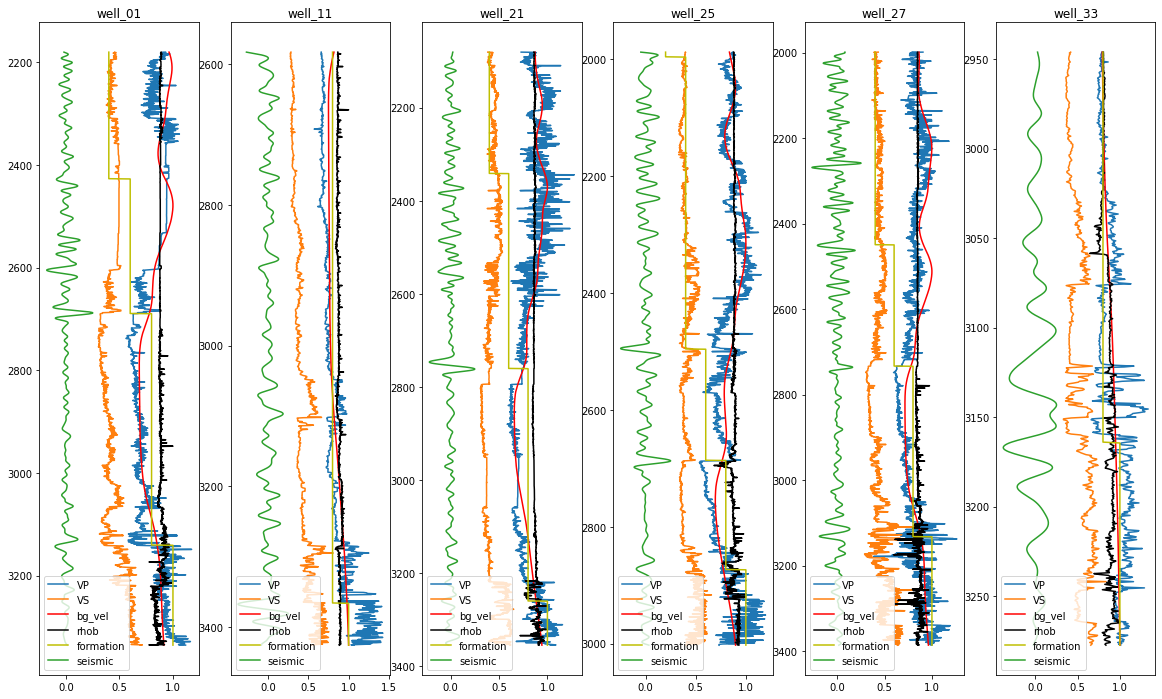

In [51]:
fig, axs = plt.subplots(1,6, figsize=(20,12))
i=0
new_attributes = True
for well in wells:
    if new_attributes == True:
        axs[i].plot(cleaned_data.loc[well]['vp']/max(cleaned_data.loc[well]['bg_vel']),cleaned_data.loc[well]['twt'],label='VP')
        axs[i].plot(cleaned_data.loc[well]['vs']/max(cleaned_data.loc[well]['bg_vel']),cleaned_data.loc[well]['twt'],label='VS')
        axs[i].plot(cleaned_data.loc[well]['bg_vel']/max(cleaned_data.loc[well]['bg_vel']),cleaned_data.loc[well]['twt'],label='bg_vel',color='r')
        axs[i].plot(cleaned_data.loc[well]['rhob']/max(cleaned_data.loc[well]['rhob']),cleaned_data.loc[well]['twt'],label='rhob',color='k')
        axs[i].plot(cleaned_data.loc[well]['formation']/max(cleaned_data.loc[well]['formation']),cleaned_data.loc[well]['twt'],label='formation',color='y')
        axs[i].plot(cleaned_data.loc[well]['seis_near']/(4*max(cleaned_data.loc[well]['seis_near'])),cleaned_data.loc[well]['twt'],label='seismic')

    if new_attributes == False:    
        axs[i].plot(cleaned_data.loc[well]['seis_near_inst_Freq']/max(cleaned_data.loc[well]['seis_near_inst_Freq']),cleaned_data.loc[well]['twt'],label='seis_near_inst_Freq',color='y')
        axs[i].plot(cleaned_data.loc[well]['seis_near_inst_Phs']/max(cleaned_data.loc[well]['seis_near_inst_Phs']),cleaned_data.loc[well]['twt'],label='seis_near_inst_Phs',color='k')
        axs[i].plot(cleaned_data.loc[well]['seis_near_ampW_inst_Freq']/max(cleaned_data.loc[well]['seis_near_ampW_inst_Freq']),cleaned_data.loc[well]['twt'],label='seis_near_ampW_inst_Freq',color='b')

    axs[i].invert_yaxis()
    axs[i].title.set_text(well)
    axs[i].legend();
    i += 1